# Problem Analysis Workshop 3 
## Canada CPI dataset 
**Course:** PROG8431  
**Team:** *Jatinder Pal Singh*  
**Student ID** : *9083762*  
**Dataset:** *Statistics Canada — Table 18‑10‑0005‑01 (Annual average CPI, 2021=100), exported as a tab‑separated file.*

### Steps
1. Cleaning
2. Standardize
3. Clustring


## Imports & Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Path to your tab-separated CPI file (update if your filename differs)
CSV_PATH = "data/CPI_annual_average_1810000501-eng_clean.csv"


## Statistics Canada's All-items CPI (wide format).
    Steps:
      1) Load wide-format CPI dataset (tab-separated, first col = category, next cols = years)
      2) Melt to long format (Year, CPI_Index)
      3) Select All-items CPI
      4) Engineer YoY % change and 3-year rolling volatility
      5) Choose K via silhouette and fit K-Means
      6) Visualize CPI vs Year and CPI vs YoY%
    

### ClusterClass

In [2]:
class ClusterClass:
   
    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = None
        self.long_df = None
        self.feat_df = None
        self.kmeans = None
        self.best_k = None
        self.best_score = None
        self.scores = {}

    def load_and_transform(self):
        # Read as tab-separated (StatCan export often uses tabs in this format)
        self.df = pd.read_csv(self.csv_path, sep="\t")
        # Drop wholly-empty columns
        self.df = self.df.dropna(how="all", axis=1)

        # Detect year columns (strings that are digits)
        year_cols = [c for c in self.df.columns if isinstance(c, str) and c.isdigit()]
        if not year_cols:
            raise ValueError("No year columns detected. Ensure the file is wide-format with years as column headers.")

        # Melt wide into long format
        first_col = self.df.columns[0]
        self.long_df = self.df.melt(
            id_vars=[first_col],
            value_vars=year_cols,
            var_name="Year",
            value_name="CPI_Index"
        ).rename(columns={first_col: "Category"})

        # Clean numeric types
        self.long_df["Year"] = pd.to_numeric(self.long_df["Year"], errors="coerce")
        self.long_df["CPI_Index"] = pd.to_numeric(self.long_df["CPI_Index"], errors="coerce")
        self.long_df = self.long_df.dropna(subset=["Year", "CPI_Index"]).sort_values("Year")
        # Keep only All-items
        self.long_df = self.long_df[self.long_df["Category"].astype(str).str.strip() == "All-items"].reset_index(drop=True)
        return self.long_df

    def engineer_features(self):
        df = self.long_df.copy()
        df["YoY_Pct_Change"] = df["CPI_Index"].pct_change() * 100.0
        df["YoY_3yr_RollingStd"] = df["YoY_Pct_Change"].rolling(window=3, min_periods=2).std()
        # Drop initial NaNs from pct_change/rolling
        self.feat_df = df.dropna(subset=["CPI_Index", "YoY_Pct_Change", "YoY_3yr_RollingStd"]).reset_index(drop=True)
        return self.feat_df

    def perform_clustering(self, k_min: int = 2, k_max: int = 6):
        X = self.feat_df[["CPI_Index", "YoY_Pct_Change", "YoY_3yr_RollingStd"]].values
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        best_k, best_score = None, -1
        scores = {}
        for k in range(k_min, k_max + 1):
            km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
            labels = km.fit_predict(X_scaled)
            if len(set(labels)) > 1:
                score = silhouette_score(X_scaled, labels)
                scores[k] = score
                if score > best_score:
                    best_k, best_score = k, score

        self.best_k, self.best_score, self.scores = best_k, best_score, scores
        self.kmeans = KMeans(n_clusters=best_k if best_k else 3, n_init=10, random_state=RANDOM_STATE)
        self.feat_df["Cluster"] = self.kmeans.fit_predict(X_scaled)
        return self.feat_df, best_k, best_score

    def plot_cpi_over_time(self):
        # One plot, default colors (no style or color set)
        plt.figure(figsize=(10, 6))
        plt.scatter(self.feat_df["Year"], self.feat_df["CPI_Index"], c=self.feat_df["Cluster"])
        plt.xlabel("Year")
        plt.ylabel("CPI Index (2021=100)")
        plt.title(f"Canada All-Items CPI — Clustered by Inflation Regime (k={self.best_k})")
        plt.colorbar(label="Cluster")
        plt.tight_layout()
        plt.show()

    def plot_feature_space(self):
        # One plot, default colors (no style or color set)
        plt.figure(figsize=(10, 6))
        plt.scatter(self.feat_df["CPI_Index"], self.feat_df["YoY_Pct_Change"], c=self.feat_df["Cluster"])
        plt.xlabel("CPI Index (2021=100)")
        plt.ylabel("YoY Inflation (%)")
        plt.title(f"Feature Space: CPI vs YoY Inflation — Canada (k={self.best_k})")
        plt.colorbar(label="Cluster")
        plt.tight_layout()
        plt.show()

    def summaries(self):
        s1 = ("The Statistics Canada All-items CPI dataset captures annual inflation trends. "
              "By clustering CPI level, annual percent change, and 3-year volatility, we identify "
              "inflation regimes that describe stable, moderate, and high-inflation periods in Canada's economy.")
        s2 = (f"K-Means selected k={self.best_k} (silhouette={self.best_score:.3f}). "
              "Distinct clusters reveal different inflation volatility regimes, confirming data-driven segmentation "
              "of Canada’s historical CPI patterns useful for forecasting and economic policy analysis.")
        return s1, s2


## Calling the ClusterClass 

Best k: 4
Silhouette scores: {2: 0.44246077449458787, 3: 0.43266421004189576, 4: 0.45330820713424136, 5: 0.3950959738595918, 6: 0.3915933018820376}


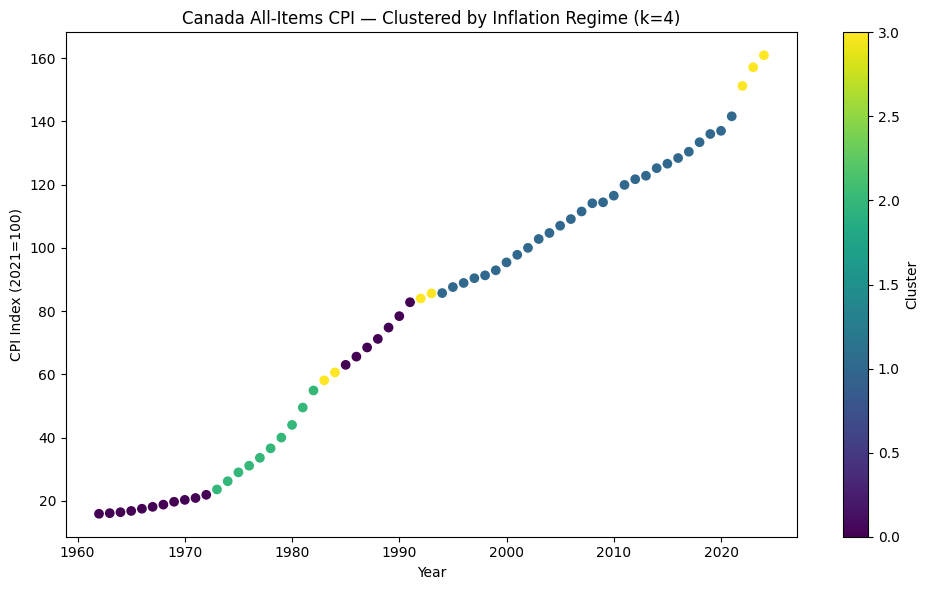

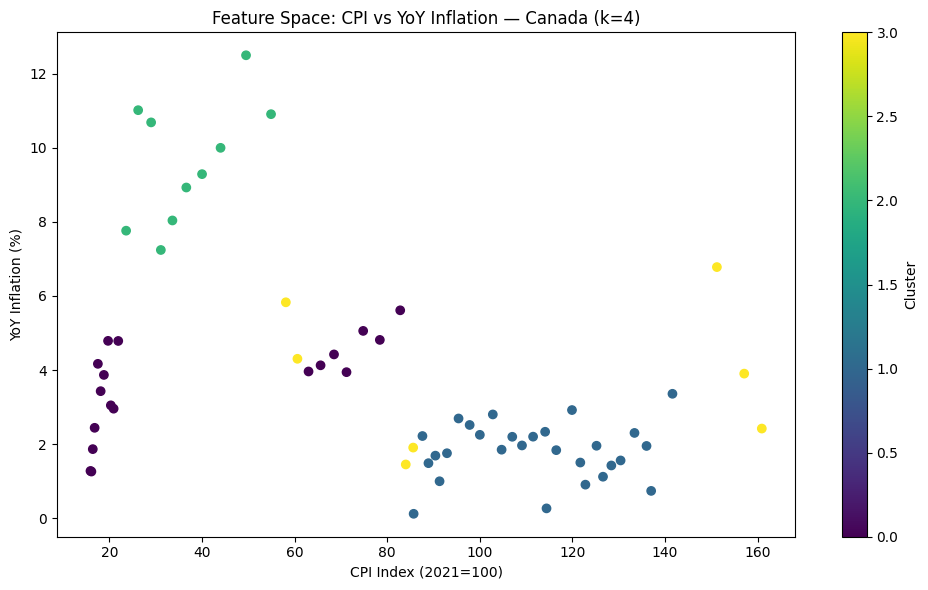


--- 50-Word Summary — How Clustering Applies ---
 The Statistics Canada All-items CPI dataset captures annual inflation trends. By clustering CPI level, annual percent change, and 3-year volatility, we identify inflation regimes that describe stable, moderate, and high-inflation periods in Canada's economy.

--- 50-Word Summary — Output Interpretation ---
 K-Means selected k=4 (silhouette=0.453). Distinct clusters reveal different inflation volatility regimes, confirming data-driven segmentation of Canada’s historical CPI patterns useful for forecasting and economic policy analysis.


,Category,Year,CPI_Index,YoY_Pct_Change,YoY_3yr_RollingStd,Cluster
0,All-items,1962,15.9,1.273885,0.011623,0
1,All-items,1963,16.1,1.257862,0.016231,0
2,All-items,1964,16.4,1.863354,0.345049,0
3,All-items,1965,16.8,2.439024,0.590644,0
4,All-items,1966,17.5,4.166667,1.198707,0
5,All-items,1967,18.1,3.428571,0.866866,0
6,All-items,1968,18.8,3.867403,0.371240,0
7,All-items,1969,19.7,4.787234,0.693377,0
8,All-items,1970,20.3,3.045685,0.871235,0
9,All-items,1971,20.9,2.955665,1.032452,0


In [3]:
cpi = ClusterClass(CSV_PATH)
_ = cpi.load_and_transform()
_ = cpi.engineer_features()
feat_df, best_k, best_score = cpi.perform_clustering()

print("Best k:", best_k)
print("Silhouette scores:", cpi.scores)

cpi.plot_cpi_over_time()
cpi.plot_feature_space()

app_summary, out_summary = cpi.summaries()
print("\n--- 50-Word Summary — How Clustering Applies ---\n", app_summary)
print("\n--- 50-Word Summary — Output Interpretation ---\n", out_summary)

# Show a preview of the processed features
feat_df.head(15)

### 50-Word Summary — How Clustering Applies
 The Statistics Canada All-items CPI dataset captures annual inflation trends. By clustering CPI level, annual percent change, and 3-year volatility, we identify inflation regimes that describe stable, moderate, and high-inflation periods in Canada's economy.

### 50-Word Summary — Output Interpretation
 K-Means selected k=4 (silhouette=0.453). Distinct clusters reveal different inflation volatility regimes, confirming data-driven segmentation of Canada’s historical CPI patterns useful for forecasting and economic policy analysis.

### A. Best Value for k?

Definition:
The best value of k (the number of clusters) is the one that balances compactness and separation — meaning data points inside a cluster are close together, while different clusters are well separated.

How it’s chosen:
We test multiple k values (e.g., 2 → 6).
For each k, compute the silhouette score (ranges from –1 to +1).
The highest silhouette score indicates the best cluster structure.

In our case:
Best k = 4, silhouette = 0.453,
→ meaning CPI data naturally forms 4 distinct inflation regimes across time.

### B. When does the algorithm stop?

K-Means is an iterative optimization algorithm.      
It repeats two key steps until convergence:     
Assignment Step: Each data point is assigned to the nearest cluster centroid.   
Update Step: Each cluster’s centroid is recalculated as the mean of its assigned points.

The algorithm stops when:       
Centroids no longer move significantly, or      
Cluster assignments stop changing, or       
The maximum number of iterations (default 300) is reached.

So, it ends when it reaches a stable state (convergence) — the clusters don’t improve further.

### C. What if the data is 2D, 3D, 4D, or nD?
K-Means easily extends to any number of dimensions (nD).        
2D (two features) → We can plot it easily as a scatterplot (like CPI Index vs. YoY % Change).       
3D → Can visualize with a 3D plot.      
4D or nD → Visualization gets harder, but the math still works:     
The algorithm computes Euclidean distances in n-dimensional space.      
Each centroid is a point with n coordinates (one for each feature).     
The logic of “assign to nearest centroid → update centroid → repeat” is unchanged.      
So, whether it’s 2 features or 20, K-Means still clusters based on distance in multidimensional space — it just becomes harder for humans to visualize.